Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features...
0:	learn: 0.6557912	test: 0.5138889	best: 0.5138889 (0)	total: 1.21s	remaining: 20m 10s
100:	le

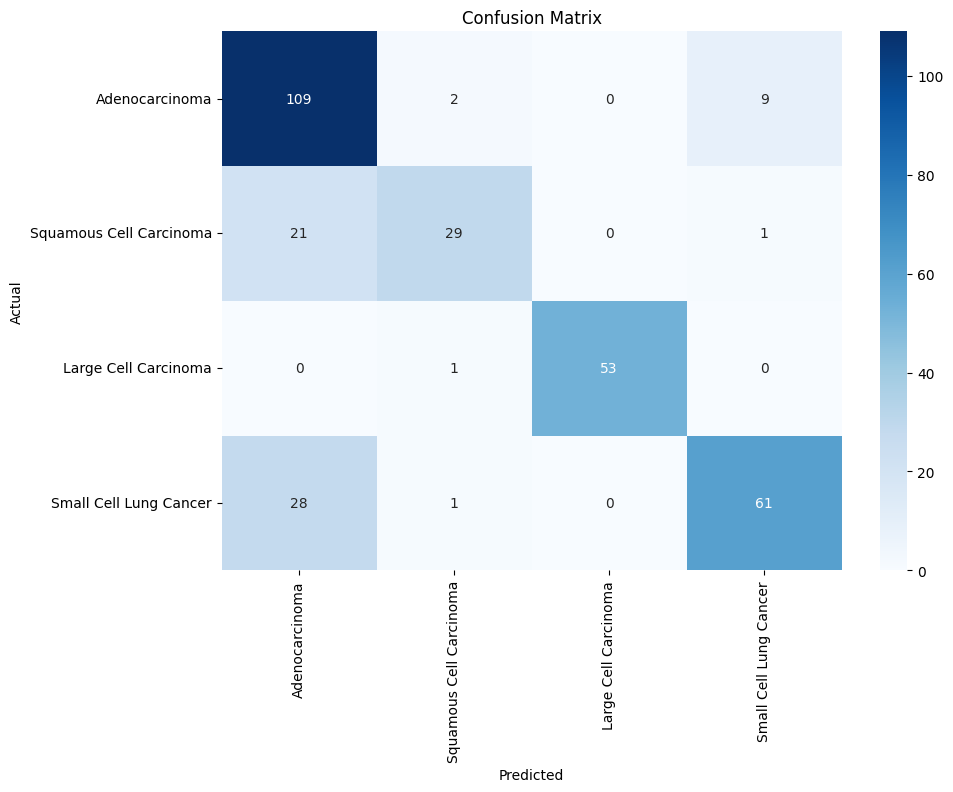

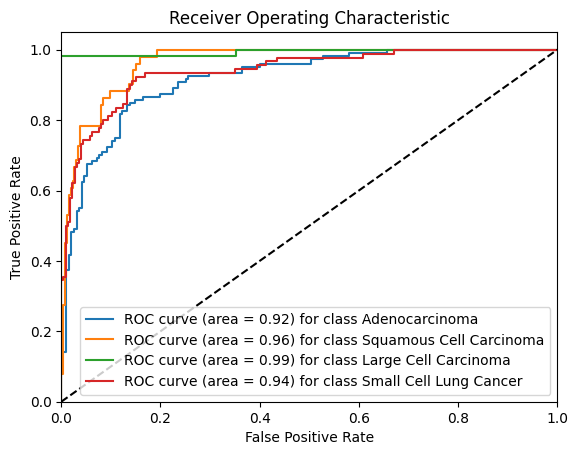

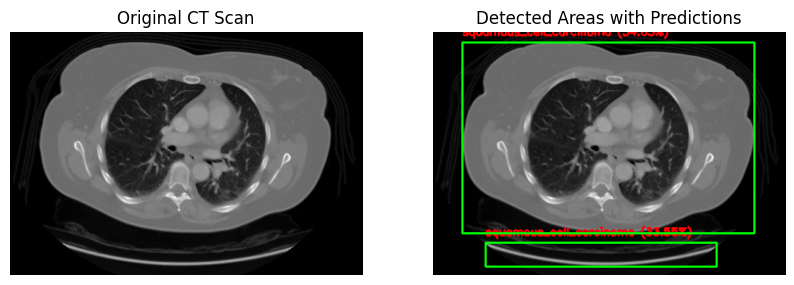

Detected area 1: squamous_cell_carcinoma with confidence 33.55%
Detected area 2: squamous_cell_carcinoma with confidence 34.65%
Final prediction result using CatBoost: squamous_cell_carcinoma with confidence 34.65%
Cancer detected by CatBoost: squamous_cell_carcinoma with confidence 34.65%
The image is classified as: squamous_cell_carcinoma with confidence 34.65% by CatBoost


In [1]:
# -*- coding: utf-8 -*-
"""CatBoost.ipynb

Adapted for CatBoost by Grok 3 (xAI).
"""

# Uninstall existing versions to avoid conflicts
!pip uninstall -y catboost numpy

# Install compatible versions of catboost and numpy
!pip install catboost numpy==1.26.4

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
train_path = "/content/drive/MyDrive/Data/train"
valid_path = "/content/drive/MyDrive/Data/valid"
test_path = "/content/drive/MyDrive/Data/test"

# Constants
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
MODEL_NAME = "CatBoost"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    dtype='float32'
)
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

valid_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
valid_generator = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_datagen = ImageDataGenerator(dtype='float32', rescale=1.0/255.0)
test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_class_names = test_generator.class_names

# Convert grayscale to RGB function
def convert_to_rgb(images):
    return tf.image.grayscale_to_rgb(images) if images.shape[-1] == 1 else images

# Feature extraction model (using EfficientNetB0)
def build_feature_extractor(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    outputs = GlobalAveragePooling2D()(x)
    model = Model(inputs, outputs)
    return model

# Extract features from dataset
def extract_features(generator, feature_extractor):
    features = []
    labels = []
    for images, lbls in generator:
        images_rgb = convert_to_rgb(images)
        feats = feature_extractor.predict(images_rgb, verbose=0)
        features.append(feats)
        labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

# Build feature extractor
feature_extractor = build_feature_extractor()

# Extract features for train, validation, and test sets
print("Extracting features...")
X_train, y_train = extract_features(train_generator, feature_extractor)
X_valid, y_valid = extract_features(valid_generator, feature_extractor)
X_test, y_test = extract_features(test_generator, feature_extractor)

# Train CatBoost model
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

# Create CatBoost Pools
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

# Train the model
catboost_model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

# Save the model
catboost_model.save_model('chestmodel_catboost.cbm')

# Evaluate the model
train_pred = catboost_model.predict_proba(X_train)
train_pred_classes = np.argmax(train_pred, axis=1)
train_acc = np.mean(train_pred_classes == y_train)
train_loss = -catboost_model.eval_metrics(train_pool, 'MultiClass')['MultiClass'][-1]
print(f'Training Loss: {train_loss}, Training Accuracy: {train_acc}')

test_pred = catboost_model.predict_proba(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
test_acc = np.mean(test_pred_classes == y_test)
test_loss = -catboost_model.eval_metrics(Pool(X_test, y_test), 'MultiClass')['MultiClass'][-1]
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Classification Report
class_names = ['Adenocarcinoma', 'Squamous Cell Carcinoma', 'Large Cell Carcinoma', 'Small Cell Lung Cancer']
print("Classification Report:")
print(classification_report(y_test, test_pred_classes, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curves
fpr = {}
tpr = {}
roc_auc = {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# CT Scan analysis with CatBoost
classifier = CatBoostClassifier()
classifier.load_model('chestmodel_catboost.cbm')
class_labels = ['adenocarcinoma', 'large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma']

# Function to preprocess and extract features for a single image
def preprocess_for_prediction(img, feature_extractor):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    features = feature_extractor.predict(img, verbose=0)
    return features

# Load the CT scan image
image_path = '/content/drive/MyDrive/Data/test/adenocarcinoma/000109 (2).png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Unable to load the image. Please check the file format and path.")
else:
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    predictions = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cropped_image = image[y:y + h, x:x + w]
            features = preprocess_for_prediction(cropped_image, feature_extractor)
            confidence_scores = classifier.predict_proba(features)[0]
            predicted_class_index = np.argmax(confidence_scores)
            predicted_class = class_labels[predicted_class_index]
            confidence = round(100 * confidence_scores[predicted_class_index], 2)
            predictions.append((predicted_class, confidence))
            cv2.putText(output_image, f"{predicted_class} ({confidence}%)", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original CT Scan')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Detected Areas with Predictions')
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

    # Print individual predictions
    for i, (pred_class, conf) in enumerate(predictions):
        print(f'Detected area {i + 1}: {pred_class} with confidence {conf}%')

    # Detection logic using model name
    if predictions:
        final_pred_class, final_conf = max(predictions, key=lambda x: x[1])
        print(f'Final prediction result using {MODEL_NAME}: '
              f'{final_pred_class} with confidence {final_conf}%')

        cancer_types = ['adenocarcinoma', 'large_cell_carcinoma', 'squamous_cell_carcinoma']
        if final_pred_class.lower() in cancer_types:
            print(f"Cancer detected by {MODEL_NAME}: {final_pred_class} with confidence {final_conf}%")
        else:
            print(f"No cancer detected by {MODEL_NAME}: {final_pred_class} with confidence {final_conf}%")

        print(f"The image is classified as: {final_pred_class} with confidence {final_conf}% "
              f"by {MODEL_NAME}")
    else:
        print("No significant areas detected.")
        print(f"The image type cannot be determined by {MODEL_NAME} due to no detectable areas.")